<a href="https://colab.research.google.com/github/ZappD0S/MLPNS_GZappavigna/blob/main/TimeSeriesClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering analysis on population trends

You are clustering the "shape" of time series to find trends, specifically, population growth trends. Do any countries stand out in the population growth trends in the past 60 years? are there groups of countries that have similar trends (and why?)

NOTE: your clusters may not be identical to mine!
## Imports

In [2]:
pip install xlrd==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## you need to restart the kernel after you do this

In [3]:
import pandas as pd
import pylab as pl
import numpy as np

from sklearn import preprocessing
from sklearn import cluster

pl.rcParams['font.size'] = 10

This is done inorder to read the excel file from my drive. 

# Data processing

## Get the data

The data will be pulled from the drive. So, here I mount my google drive and get it from `https://github.com/fedhere/MLPNS_FBianco/tree/main/clustering`. The file name is `SP.POP.TOTL?downloadformat=excel`

Will have to skip some rows (`skiprows=`) and ideally only use relevant columns (the country name and each year column from 1960, you can use `usecold=` 

Finally, will set the country name as the index for this dataframe. Will do that with `set_index()` passing the relevant column name as the argument (Not forgeting the idea is to wanting to do it inplace! `inplace=True`)

In [4]:
#reading in the data from the excel in the github repo, subfolder clustering
#use skiprows to gewt the right format

url = "https://github.com/fedhere/MLPNS_FBianco/blob/main/clustering/SP.POP.TOTL_downloadformat=excel?raw=true"
pop_df = pd.read_excel(url, skiprows=3)
pop_df 

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,...,14023199.0,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0


In [5]:
columns = ['Country Name', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']    
#throw away unnecessary columns
pop_df = pop_df[columns]  

pop_df.set_index("Country Name", inplace=True)                 

In [6]:
print("The shape of the original dataset is: ", pop_df.shape)

The shape of the original dataset is:  (266, 61)


In [7]:
#Checking the data content from the first 5 rows
pop_df.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,58734.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,165611760.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,10893772.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,117468741.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
Angola,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,5803677.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0


In [8]:
pop_df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,...,2.650000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02
mean,1.173116e+08,1.188586e+08,1.209679e+08,1.235882e+08,1.262297e+08,1.289366e+08,1.317868e+08,1.346309e+08,1.375436e+08,1.405603e+08,...,2.828664e+08,2.876904e+08,2.914996e+08,2.953218e+08,2.991360e+08,3.029648e+08,3.068068e+08,3.105688e+08,3.142511e+08,3.178433e+08
std,3.705555e+08,3.749081e+08,3.814322e+08,3.899277e+08,3.984666e+08,4.072394e+08,4.165735e+08,4.258523e+08,4.353820e+08,4.452976e+08,...,8.906976e+08,9.033226e+08,9.145177e+08,9.257010e+08,9.368180e+08,9.479474e+08,9.591275e+08,9.699792e+08,9.805328e+08,9.907252e+08
min,2.833000e+03,3.077000e+03,3.367000e+03,3.703000e+03,4.063000e+03,4.460000e+03,4.675000e+03,4.922000e+03,5.194000e+03,5.461000e+03,...,1.006900e+04,1.013600e+04,1.020800e+04,1.028900e+04,1.037400e+04,1.047400e+04,1.057700e+04,1.067800e+04,1.076400e+04,1.083400e+04
25%,5.022802e+05,5.109642e+05,5.206540e+05,5.311622e+05,5.421252e+05,5.533362e+05,5.647475e+05,5.823645e+05,5.981078e+05,6.100030e+05,...,1.562996e+06,1.539939e+06,1.574621e+06,1.609909e+06,1.645868e+06,1.689616e+06,1.716772e+06,1.740174e+06,1.751950e+06,1.756929e+06
50%,3.718330e+06,3.826398e+06,3.929109e+06,4.015834e+06,4.124521e+06,4.242788e+06,4.326013e+06,4.387887e+06,4.474171e+06,4.550402e+06,...,9.461643e+06,9.824808e+06,9.948838e+06,1.001582e+07,1.022085e+07,1.036160e+07,1.040671e+07,1.045548e+07,1.047907e+07,1.052617e+07
75%,2.636053e+07,2.721235e+07,2.808607e+07,2.890669e+07,2.972333e+07,3.055227e+07,3.134845e+07,3.200449e+07,3.244145e+07,3.277149e+07,...,5.937945e+07,6.057984e+07,6.120753e+07,6.174243e+07,6.182699e+07,6.187352e+07,6.191725e+07,6.193141e+07,6.150589e+07,6.160448e+07
max,3.032156e+09,3.071596e+09,3.124561e+09,3.189656e+09,3.255146e+09,3.322047e+09,3.392098e+09,3.461620e+09,3.532783e+09,3.606554e+09,...,7.003760e+09,7.089255e+09,7.175500e+09,7.261847e+09,7.347679e+09,7.433569e+09,7.519183e+09,7.602454e+09,7.683372e+09,7.761620e+09


##Data Cleaning 
Are there missing values?? 
To remove NaNs and also remove any other unwanted columns or rows

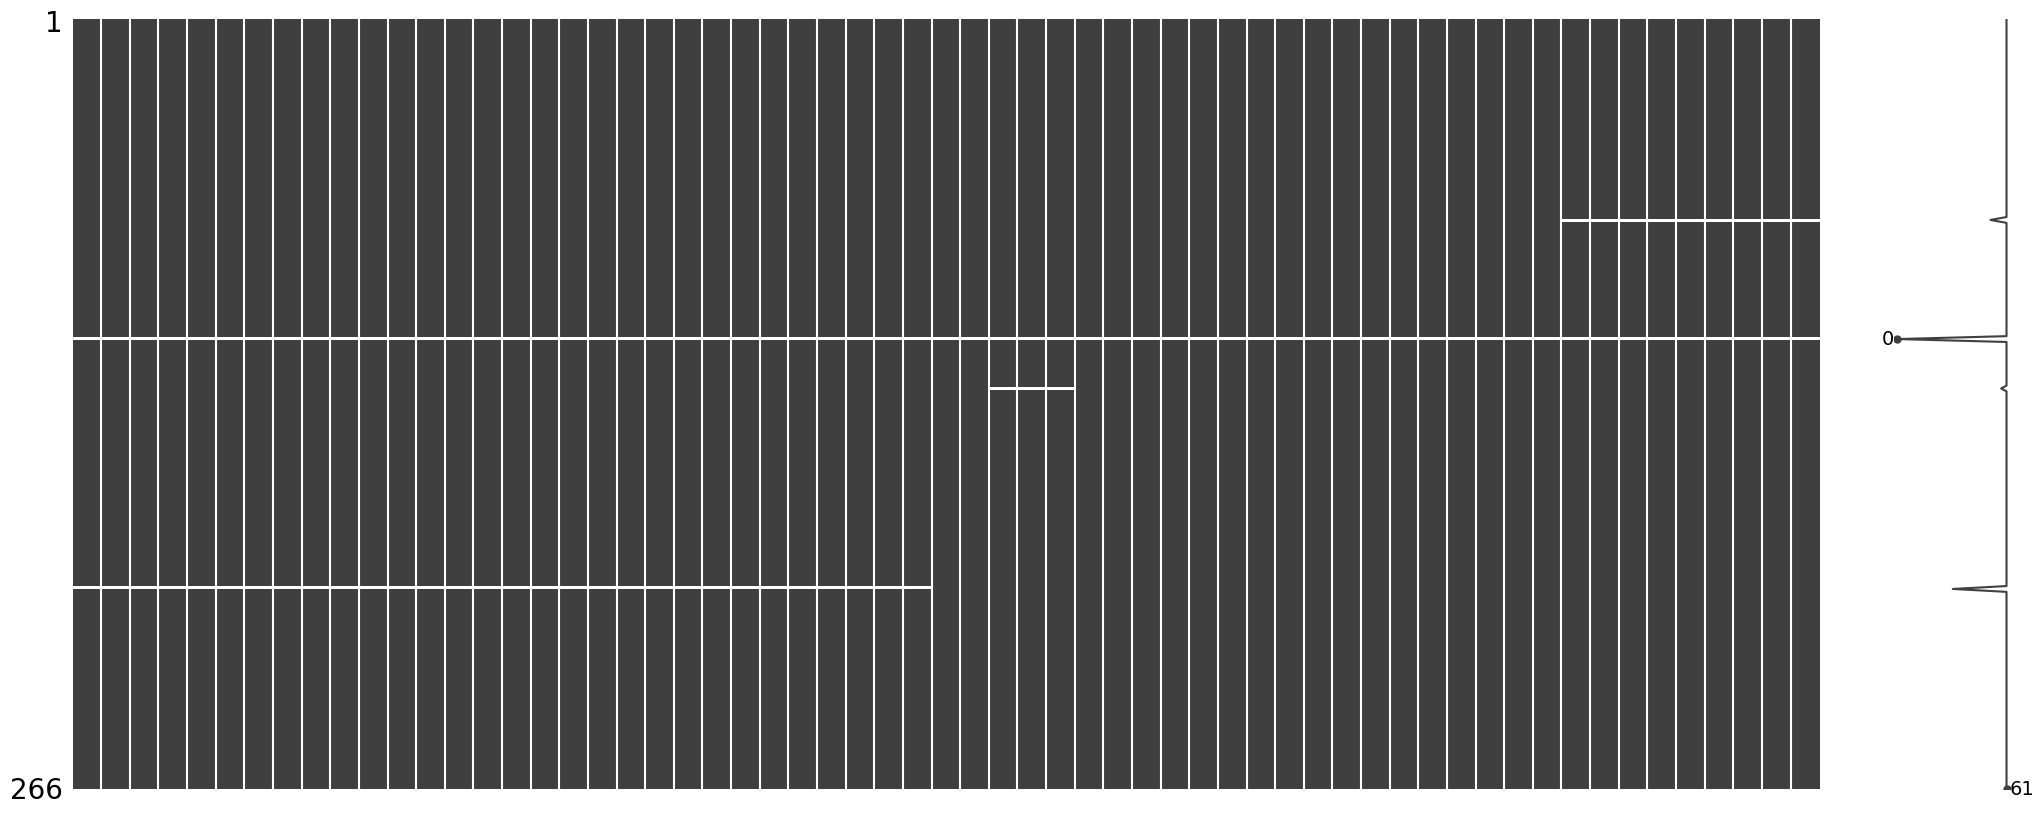

In [9]:
#this package visualizes ,issing values
import missingno as msno
msno.matrix(pop_df);

In [10]:
#would you drop _rows_ with missing values, or _columns_ ?
#choose the right axis in this call
pop_df_clean = pop_df.dropna(axis=0) 

In [11]:
#Determining the shape of the data
print("The shape of the cleaned dataset is: ", pop_df_clean.shape)

The shape of the cleaned dataset is:  (262, 61)


In [12]:
#Checking the content of the first 5 rows of the cleaned  dateset with NO NaNs 
pop_df_clean.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,58734.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,165611760.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,10893772.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,117468741.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
Angola,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,5803677.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0


In [13]:
#Checking the content of the last 5 rows of the cleaned  dateset with NO NaNs 
pop_df_clean.tail()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,,,,,,,,,,,,,,,,,,,,,
Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,1191000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
"Yemen, Rep.",5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,5816241.0,5907873.0,6001858.0,6097042.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
South Africa,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,19888259.0,20406863.0,20942147.0,21496075.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0
Zambia,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,3681953.0,3797877.0,3918872.0,4045740.0,...,14023199.0,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0
Zimbabwe,3776679.0,3905038.0,4039209.0,4178726.0,4322854.0,4471178.0,4623340.0,4779825.0,4941901.0,5111326.0,...,12894323.0,13115149.0,13350378.0,13586710.0,13814642.0,14030338.0,14236599.0,14438812.0,14645473.0,14862927.0


## Scaling (standardizing)

Standardize the data: We are working with time series, so each datapoint (=each country) has to be mean 0 and standard deviaion 1 along the rows (that is axis 1)

We use the `preprocessing.scale` function. Make sure you check! you want eavery country mean to be 0 and every country standard deviation to be 1...

In [14]:
pop_df_clean.dtypes

1960    float64
1961    float64
1962    float64
1963    float64
1964    float64
         ...   
2016    float64
2017    float64
2018    float64
2019    float64
2020    float64
Length: 61, dtype: object

In [15]:
# maxs = pop_df_clean.max(axis=1)
# pop_df_clean = pop_df_clean.loc[maxs < maxs.quantile(0.95)]

In [16]:
# standardizing the data
X = pop_df_clean.values
pop_standard = preprocessing.scale(X, axis=1)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [17]:
print(pop_standard.mean(axis=1), pop_standard.std(axis=1)) #all means should be ~0, alll std ~ 1

[ 1.09202265e-17 -6.55213588e-16  6.33373135e-16  2.69365586e-16
  4.00408304e-16 -2.27504718e-17 -9.20939099e-16  2.65725511e-16
 -4.58649512e-16  9.02738722e-16 -7.73516042e-17  5.11430606e-16
  7.06174645e-16 -7.13454796e-16 -8.88178420e-16 -5.67851777e-16
 -3.49447247e-16  0.00000000e+00 -6.33373135e-16  6.33373135e-16
 -9.20939099e-16  6.18812833e-17  4.29528908e-16 -4.00408304e-17
  3.67647625e-16  4.27708870e-17 -3.64007549e-17  8.95458571e-16
 -3.09406417e-16 -9.75540231e-16 -3.64007549e-18  8.51777665e-16
  2.25684680e-16  6.77054041e-16  5.71491852e-16 -2.91206039e-17
  3.64007549e-17 -7.20734947e-16 -1.18666461e-15 -9.82820382e-16
 -6.95254419e-16 -5.60571626e-16  7.35295249e-16 -2.54805284e-16
 -9.46419628e-17 -1.16482416e-16 -3.56727398e-16 -3.02126266e-16
  5.96972380e-16 -7.24375023e-16 -7.35295249e-16  3.64007549e-17
 -1.82003775e-16 -8.22657061e-16 -2.91206039e-17  7.64415853e-17
 -7.71696004e-16  4.45909248e-17 -1.45603020e-17  5.16890720e-16
  6.11532682e-16  8.08096

In [18]:
pop_df_clean.shape

(262, 61)

## Visualize the data

Making a plot of the time series before scaling, and after scaling. What do you see in the scaled version that was lost before? Dont forget to write a caption!

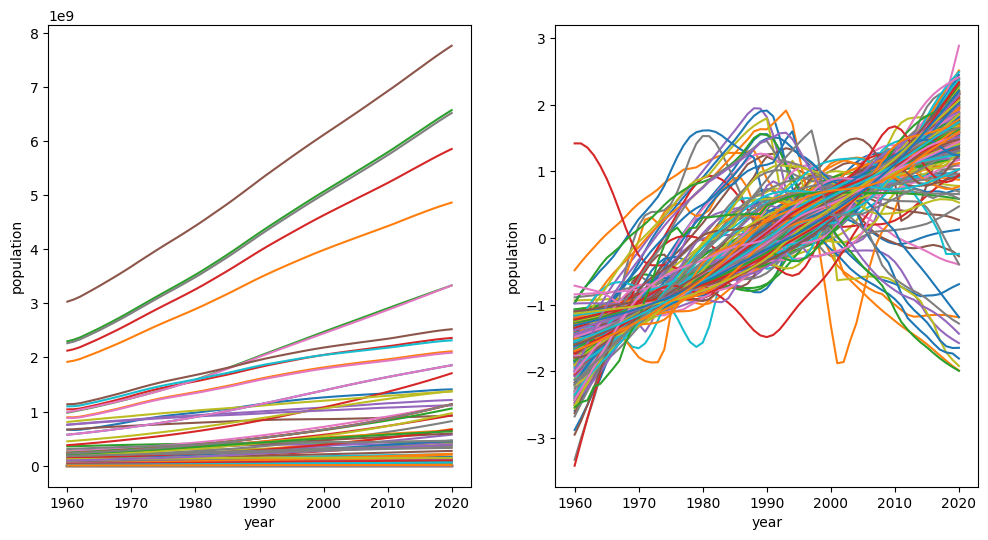

In [19]:
# looking at the data
fig, [ax1, ax2] = pl.subplots(1,2, figsize=(12,6)) #plot the original and standardized plot side by side

years = pop_df_clean.columns.astype("int")

pop_standard_df = pd.DataFrame(index=pop_df_clean.index, columns=pop_df_clean.columns, data=pop_standard)

ax1.set_xlabel("year")
ax2.set_xlabel("year")

ax1.set_ylabel("population")
ax2.set_ylabel("population")


for state in pop_df_clean.index:
    # pop_df_clean.loc[]
    ax1.plot(years, pop_df_clean.loc[state].values)
    ax2.plot(years, pop_standard_df.loc[state].values)
    # ax1.plot(pop_df_clean.loc[state])
    # ax2.plot(pop_standard_df.loc[state])

Figure 1(a): Shows the population (in billions) of various countries represented in in different colors between 1960 and 2020 Before Scaling.

Figure 1(b): Shows the same population in a standadized scale represented in in different colors between 1960 and 2020 after Scaling. We now see a proper trend of the data that was lost before scaling.

# Make a cluster model with KMeans
Use kmeans (`sklearn.cluster.KMeans`) to cluster the data. Make 9 models for number of clusters = 2, 3, 4, 5, 6, 7, 8, 9, 10. 

For each model, fit the data and calculate the "inertia" which is 

# Use an elbow plot to figure out ideal cluster _n_ 

In [20]:
# For n_clusters = 2 this would look as:
model = cluster.KMeans(n_clusters = 2)
model.fit(pop_standard)
v = model.inertia_
print('The model inertia is:', f"{v:.4f}" )


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The model inertia is: 1249.5287


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

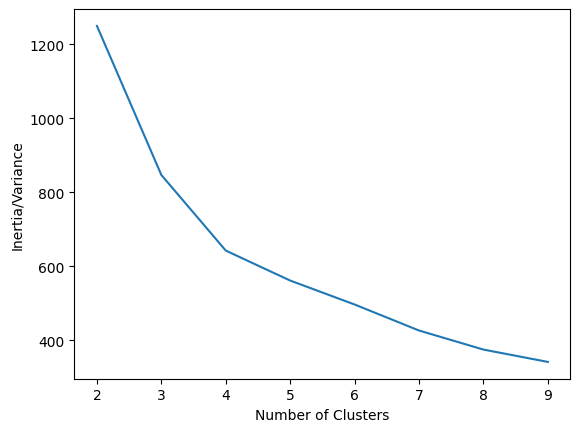

In [21]:
# Now using the "inertia" (intracluster variance essentially) to make an Elbow plot: 
# inertia is the y axis, the number of clusters are the x axis.
# Now assessing if the elbow plot shows an inflection, which can be used to determine the "right" number of clusters
inertia = []
for i in range(2, 10): 
  model = cluster.KMeans(n_clusters = i).fit(pop_standard)
  inertia.append(model.inertia_)
pl.plot(range(2, 10), inertia)
pl.xlabel("Number of Clusters")
pl.ylabel("Inertia/Variance");

Figure 2: "Elbow plot" of k-means clustering of our time series. The y axis shows the sum of squared distances to the closest centroid. The point where inertia/variance dramatically drops in an elbow plot is recommended as the preferred number of clusters; this line has a bit too much of a gradual descent to make an effective recommendation. 

## Pick the hyperparameters
Pick the model you prefer from the suite of models above, plot the data for each cluster separately. 
If for example you have made 4 clusters, then you fould do:

```
fig,ax = pl.subplots(2,2, figsize=(12,14))


ax[0,0].set_title("Cluster 1")
ax[0,0].set_xticks(range(0,70,10))
ax[0,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,0].plot(pop_standard[model.label_[1] == 0].T, "k", alpha=0.2);
ax[0,0].plot(c[0][0], color="hotpink")

ax[0,1]....

ax[1,0]....

ax[1,1]....
```

In [22]:
n_clusters=4
model = cluster.KMeans(n_clusters=n_clusters, random_state=302)
model.fit(pop_standard)
v = model.inertia_
print('The model inertia is:', f"{v:.4f}" )

The model inertia is: 642.5573


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
#Here we now chech the model lables
model.labels_

array([0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2,
       0, 1, 2, 3, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 3, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 3, 0, 0, 3, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 3, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       1, 0, 3, 0, 1, 3, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 3, 3, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 0, 3, 0, 0, 0, 1, 1, 1,
       3, 0, 0, 1, 1, 3, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 3, 1, 1, 1, 1, 1, 1, 0, 2,
       3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 3, 1, 0, 1, 1, 1, 1,
       0, 0, 2, 1, 1, 1, 1, 3, 1, 0, 3, 1, 0, 1, 1, 3, 0, 1, 0, 1],
      dtype=int32)

In [24]:
#Definting the models c, and determine the model centers in the k-means cluster
c = model.cluster_centers_

In [25]:
c.shape

(4, 61)

In [26]:
pop_standard[model.labels_ == 0].T.shape

(61, 112)

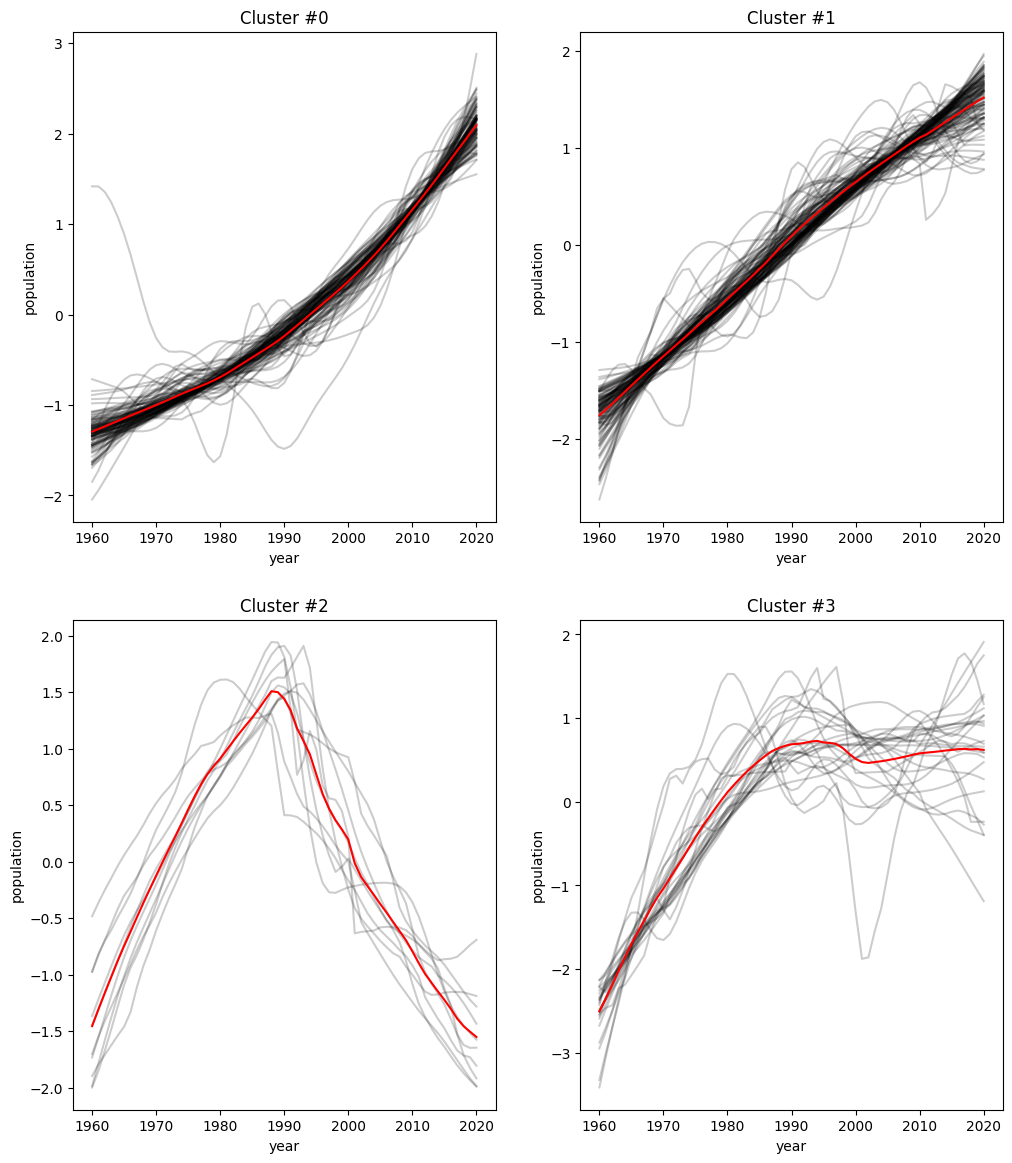

In [27]:
fig, axs = pl.subplots(2,2, figsize=(12,14))

for i in range(4):
    # ax = axs[np.unravel_index(i, (2, 2))]
    ax = axs.flat[i]

    ax.plot(years, pop_standard[model.labels_ == i].T, "k", alpha=0.2)
    ax.plot(years, model.cluster_centers_[i], "r")
    ax.set_xlabel("year")
    ax.set_ylabel("population")
    ax.set_title("Cluster #{}".format(i))

#... try tp reproduce the plot below; one plot per cluster, with the centroid overplotted

Figure 3: Results of using k-means clustering on the standardized data seen in Figure 1. The mean line for each cluster is visible in pink.

Cluster 1 is a a fairly linear upward trend with some outliers and cluster 4 a more curved upward trend. Cluster 2 and cluster 4 have fewer time series; 2 rises steadily before a big drop in the 1990s whereas the countries in 3 kind of hit a plateau around the 1990s. 

In [28]:
for i in range(4):
  print ("total items in cluster {:d}: {:d}".format(
      i+1, np.sum(model.labels_ == i)))

total items in cluster 1: 112
total items in cluster 2: 115
total items in cluster 3: 10
total items in cluster 4: 25


# Extra Credit: Doing the same analysis using density clustering method. 

In [29]:
cluster.DBSCAN?

In [30]:
# try to find a DBSCAN set of hyperparameter that gives upi 4 clusters. 
# are they the ssame as the kmeans ones? why? why not?

for i in np.arange(0.1, 2, 0.05):
  model = cluster.DBSCAN(eps=i, min_samples=4) 
  #hyperparameters here from the loop. which hyperparameter is the model most sensitive to?
  model.fit(pop_standard)
  if model.labels_.max() > 0:
    print("{:.2f}".format(i), model.labels_.max() + 1)

0.10 5
0.15 4
0.20 4
0.25 4
0.30 2
0.35 3
0.95 2


In [31]:
for i in np.arange(1, 10):
  model = cluster.DBSCAN(eps=0.2, min_samples=i) 
  #hyperparameters here from the loop. which hyperparameter is the model most sensitive to?
  model.fit(pop_standard)
  if model.labels_.max() > 0:
    print(i, model.labels_.max() + 1)

1 186
2 12
3 4
4 4
5 4
6 3
7 3
8 3
9 3


In [32]:
# For n_clusters = 4 this would look as:
model = cluster.DBSCAN(0.2)
model.fit(pop_standard)
model.labels_


array([-1,  0, -1,  0, -1, -1, -1,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1,  0, -1,  0,  1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  3,  2,  3, -1, -1,  2, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  2, -1,  1,
        1,  0,  0,  1,  0, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  0,  0, -1, -1,
        2,  1, -1,  3, -1, -1, -1, -1, -1,  1, -1, -1,  0, -1,  2,  1, -1,
        1, -1, -1, -1, -1,  2, -1, -1, -1, -1,  0, -1, -1, -1, -1,  2, -1,
       -1,  0,  1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  2, -1,  0,
       -1,  0, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1,  2, -1,  0,  0,
       -1,  0, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [33]:
c = np.zeros((4, pop_standard.shape[1]))

for i in range(4):
    c[i] = pop_standard[model.labels_ == i].mean(axis=0)

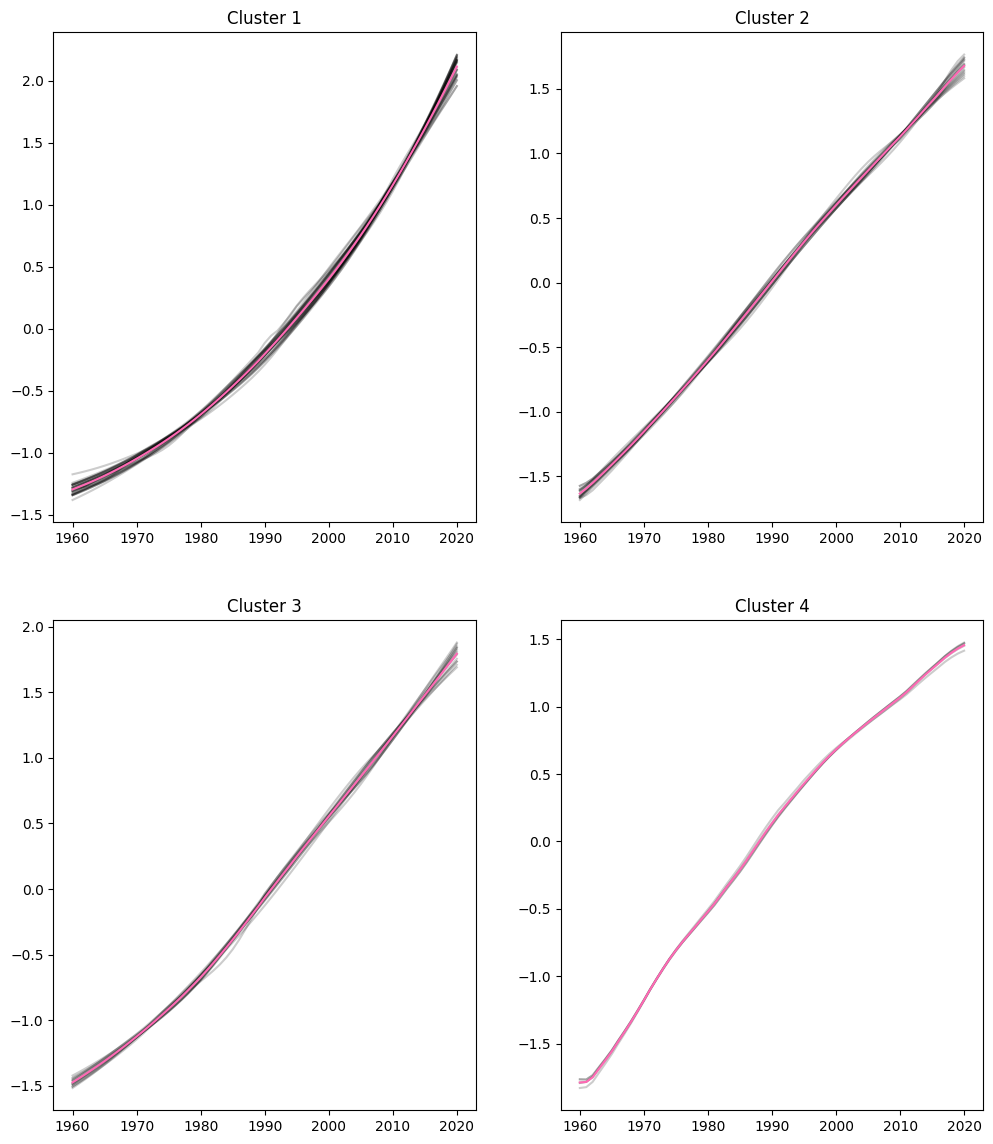

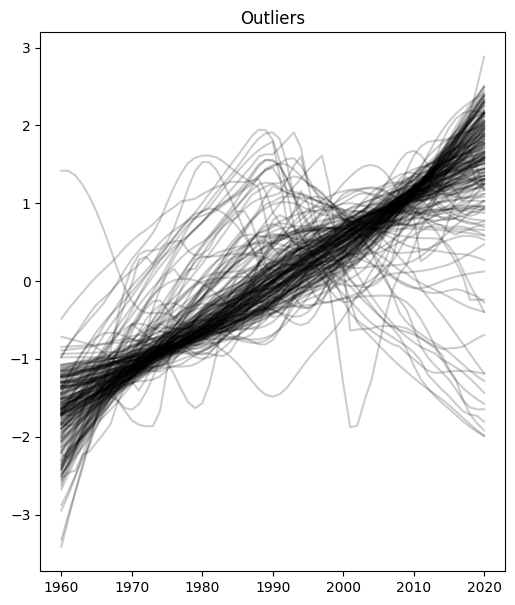

In [34]:
fig,ax = pl.subplots(2,2, figsize=(12,14))

for i in range(4):
  ax.flat[i].set_title("Cluster " + str(i+1))
  ax.flat[i].set_xticks(range(0,70,10))
  ax.flat[i].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
  ax.flat[i].plot(pop_standard[model.labels_.flat == i].T, "k", alpha=0.2);
  ax.flat[i].plot(c[i], color="hotpink")



fig, ax = pl.subplots(1,1, figsize=(6,7))
ax.set_title("Outliers")
ax.set_xticks(range(0,70,10))
ax.set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax.plot(pop_standard[model.labels_.flat == -1].T, "k", alpha=0.2);

Figure 4: Results of using DBSCAN clustering on the standardized data seen in Figure 1. The mean line for each cluster is visible in pink.

All clusters show an upward trend; cluster 2, 3 and 4 are fairly linear, while cluster 1 is more curved upward. All clusters are quit compact and there is a large number of outliers. This is due to the fact that the density measure is constant.

La ragione per cui abbiamo tanti outliers è che abbiamo scelto una distanza massima tra campioni $\epsilon$ troppo piccola. 

I campioni che formano i cluster sono campioni che sono vicini tra loro loro nel feature space e quindi corrispondo a serie temporali simili.

Le serie classificate come outliers hanno carattestiche diverse tra loro e quindi nel feature space risualtano lontane tra loro, e anche dai campioni che formano i 4 clusters.


In [35]:
# For n_clusters = 4 this would look as:
model = cluster.AgglomerativeClustering(n_clusters = 4)
model.fit(pop_standard)
model.labels_


array([1, 1, 1, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 2,
       1, 3, 2, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1,
       1, 3, 1, 3, 3, 3, 0, 0, 1, 1, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 1, 3, 3, 2, 1, 3, 1, 3, 3, 3, 0, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1,
       3, 1, 0, 1, 3, 0, 3, 3, 1, 1, 2, 3, 2, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 1, 3, 1, 3, 3, 1, 0, 0, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3,
       1, 1, 3, 3, 3, 3, 3, 3, 2, 1, 2, 1, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3,
       0, 1, 1, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3,
       3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 0, 1, 0, 3, 3, 3, 3, 3, 3, 1, 2,
       0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       3, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3,
       1, 1, 2, 3, 3, 3, 3, 0, 3, 1, 0, 3, 1, 3, 3, 0, 1, 3, 1, 3])

# Identifying the countries in the smallest clusters

plot the two smallest clusters with labels for the countries

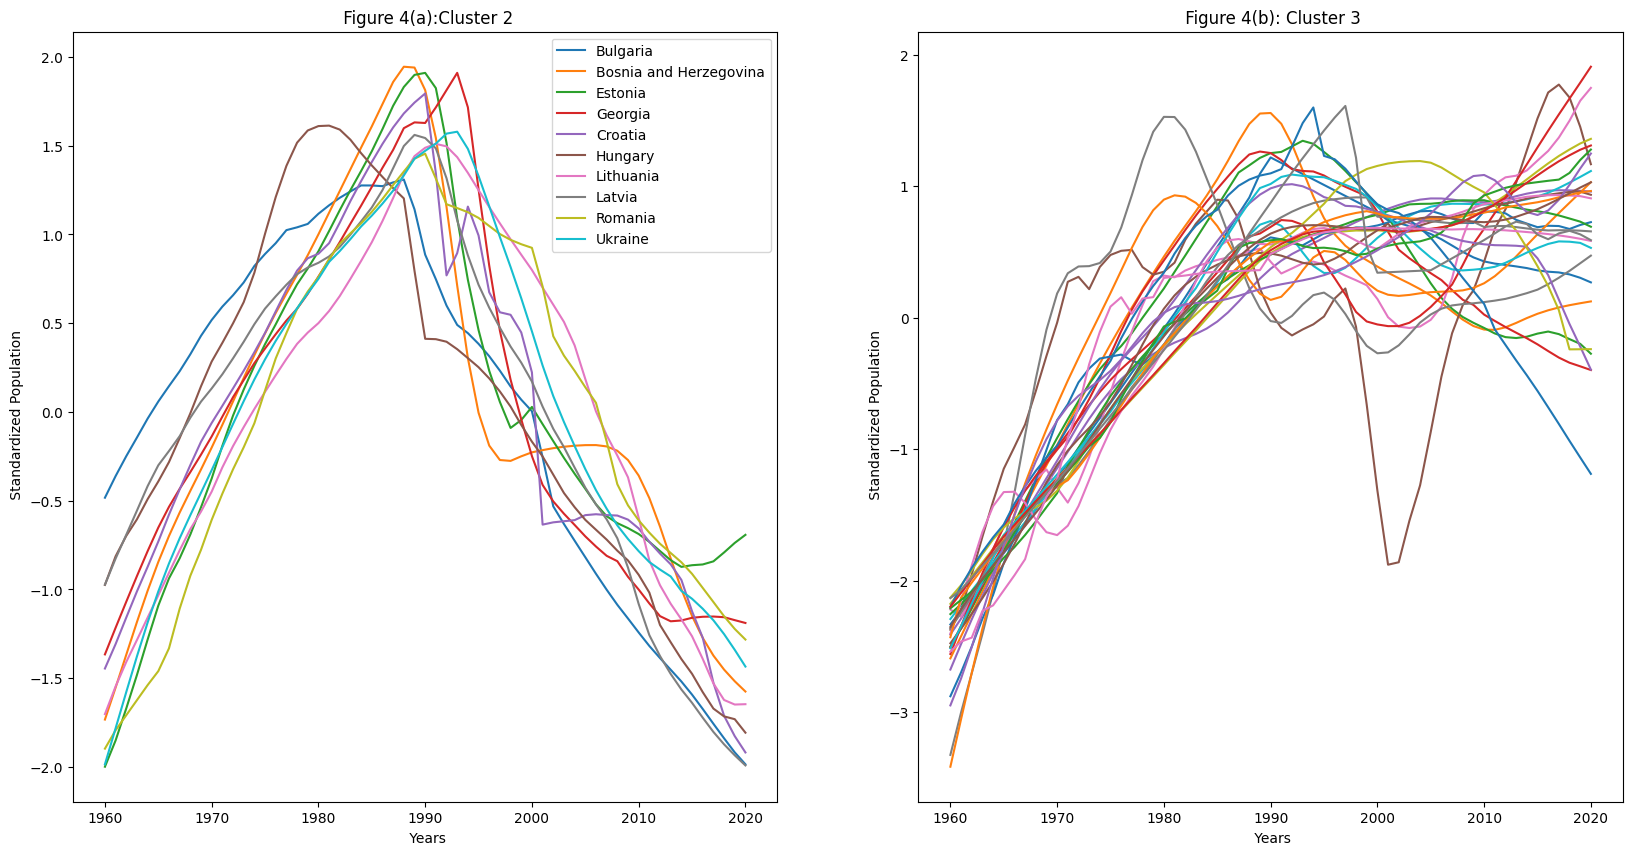

In [36]:
fig,ax = pl.subplots(1,2, figsize=(20,10))

ax[1].set_title(" Figure 4(b): Cluster 3")
ax[1].set_xticks(range(0,70,10))
ax[1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1].plot(pop_standard[model.labels_ == 0 ].T);
ax[1].set_xlabel(' Years')
ax[1].set_ylabel(' Standardized Population');



ax[0].set_title(" Figure 4(a):Cluster 2")
ax[0].set_xticks(range(0,70,10))
ax[0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0].plot(pop_standard[model.labels_ == 2 ].T);
# placing legend method via https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/

ax[0].legend(labels=pop_df_clean.loc[model.labels_ == 2].index)
ax[0].set_xlabel(' Years')
ax[0].set_ylabel(' Standardized Population');

Figure 4(a):Shows the plot of the standardized population over the years from 1960 to 2020 for the countries in the smalles cluster. Figure 4(b): Shows the plot of the standardized population over the years from 1960 to 2020 for the countries in the second smallest cluster. 

can you figure out 
- what these countries are
- what happens and why these countries are together?



